In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

import networkx as nx
import community as community_louvain

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster, PolyLineTextPath
from collections import Counter

from datetime import datetime
import calendar
import holidays
import datetime

import os
import requests
from zipfile import ZipFile
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import time
import asyncio

from html2image import Html2Image
import seaborn as sns

from scipy.stats import fligner
from scipy.stats import shapiro, bartlett, ttest_ind, mannwhitneyu

#### Open/Save data

In [2]:
tc = pd.read_csv('result/tc.csv')
data_all_uf = pd.read_csv('result/data_all.csv')
sp_trips_uf = pd.read_csv('result/sp_trips.csv')

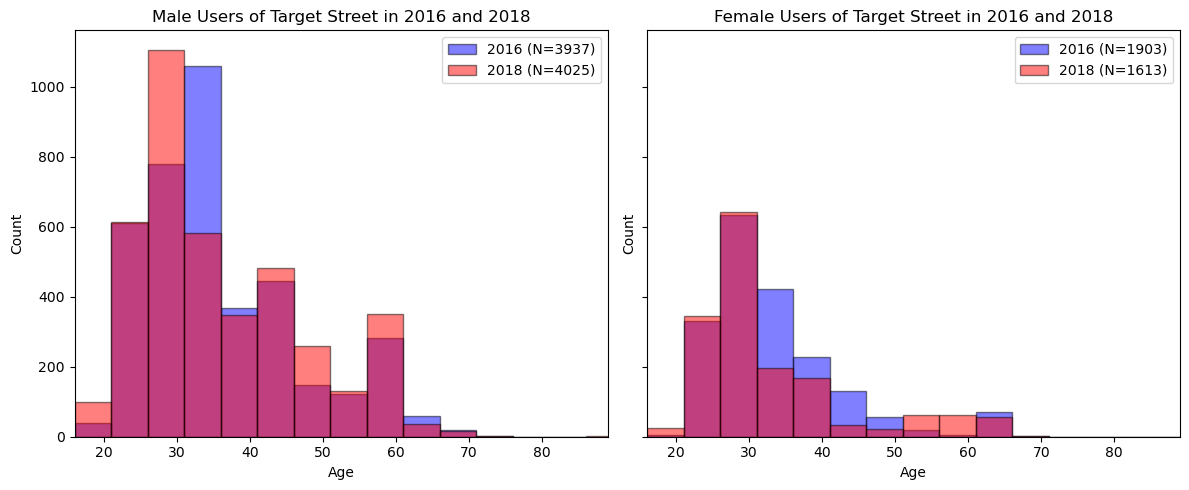

In [3]:
sp_trips_uf['age'] = sp_trips_uf['year'] - sp_trips_uf['birth year']
data_all_uf['age'] = data_all_uf['year'] - data_all_uf['birth year']

s18 = sp_trips_uf[sp_trips_uf['year'] == 2018].copy()
s16 = sp_trips_uf[sp_trips_uf['year'] == 2016].copy()

s18_male = s18[s18['gender'] == 1]
s16_male = s16[s16['gender'] == 1]
s18_female = s18[s18['gender'] == 2]
s16_female = s16[s16['gender'] == 2]

min_age = min(s16['age'].min(), s18['age'].min())
max_age = max(s16['age'].max(), s18['age'].max())
bins = range(min_age, max_age + 5, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(s16_male['age'], bins=bins, color='blue', edgecolor='black', alpha=0.5, label=f'2016 (N={len(s16_male)})')
axes[0].hist(s18_male['age'], bins=bins, color='red', edgecolor='black', alpha=0.5, label=f'2018 (N={len(s18_male)})')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Male Users of Target Street in 2016 and 2018')
axes[0].legend()
axes[0].set_xlim(min_age, max_age)

axes[1].hist(s16_female['age'], bins=bins, color='blue', edgecolor='black', alpha=0.5, label=f'2016 (N={len(s16_female)})')
axes[1].hist(s18_female['age'], bins=bins, color='red', edgecolor='black', alpha=0.5, label=f'2018 (N={len(s18_female)})')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].set_title('Female Users of Target Street in 2016 and 2018')
axes[1].legend()
axes[1].set_xlim(min_age, max_age)

plt.tight_layout()
plt.show()

In [4]:
side_1 = [88,95,90,143,84,98,109,190,47,40,171]
side_2 = [70,73,74,180,96]

side_3 = np.unique([88,95,90,143,109,190,47,40,20,94,98,171,7,24,186,31,6,23,151,43,48,192,23,35,60,54]+[58,120,35,22,141,23]).tolist()
side_4 = [104,89,108,110]

side_5 = [88]
side_6 = [15,149]

side_right = np.unique(side_1 + side_3 + side_5).tolist()
side_left  = np.unique(side_2 + side_4 + side_6).tolist()
target_nodes =  np.unique(side_right + side_left)

In [5]:
# sp_trips = sp_trips[sp_trips['start station id'].isin(target_nodes) & sp_trips['end station id'].isin(target_nodes)]
data_all2 = data_all_uf[data_all_uf['start station id'].isin(target_nodes) & data_all_uf['end station id'].isin(target_nodes)]
tc2 = tc[tc['start station id'].isin(target_nodes) & tc['end station id'].isin(target_nodes)]

In [6]:
# ssummer = sp_trips[(sp_trips['month'].isin([6,7,8]))]

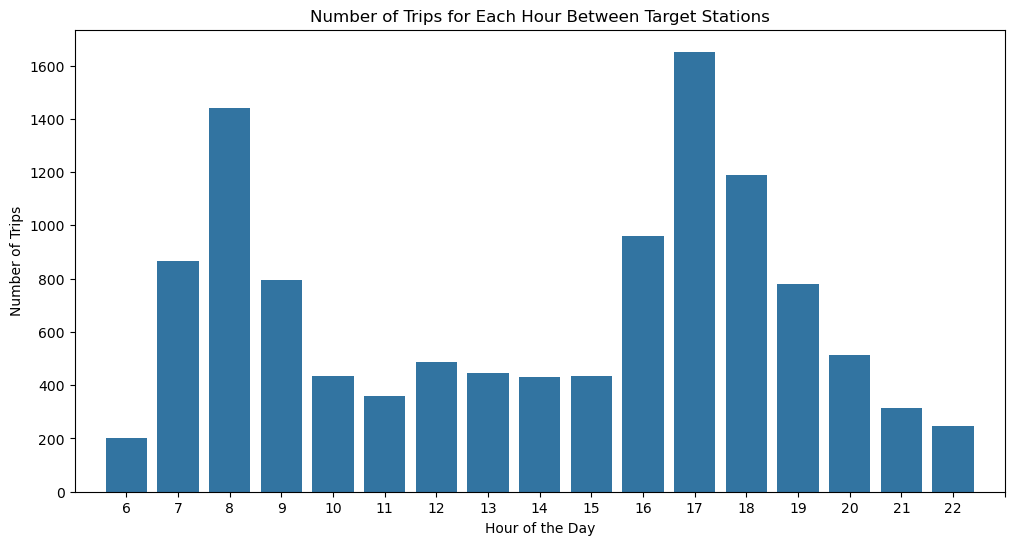

In [7]:
hourly_trip_counts = sp_trips_uf.groupby('hour').size().reset_index(name='trip_count')
# hourly_trip_counts = ssummer.groupby('hour').size().reset_index(name='trip_count')


plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='trip_count', data=hourly_trip_counts)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips for Each Hour Between Target Stations')
plt.xticks(range(24))
plt.xlim(-1,17)
plt.show()

- <= 30: More risk-taking, younger individuals.
- 31 - 50: Likely active working individuals.
- 51 - 70: Older individuals.
- 70 < : Possibly incorrect or faked data.

---------------------------------------------------------------------------------------------

## Filter percipitation

In [8]:
percp_16 = pd.read_csv('percp_16_cam.csv')
percp_18 = pd.read_csv('percp_18_cam.csv')

percp_16['date'] = pd.to_datetime(percp_16[['year', 'month', 'day']])
percp_16 = percp_16[percp_16['date'].dt.weekday < 5]
percp_16 = percp_16.drop(columns=['date'])

percp_18['date'] = pd.to_datetime(percp_18[['year', 'month', 'day']])
percp_18 = percp_18[percp_18['date'].dt.weekday < 5]
percp_18 = percp_18.drop(columns=['date'])

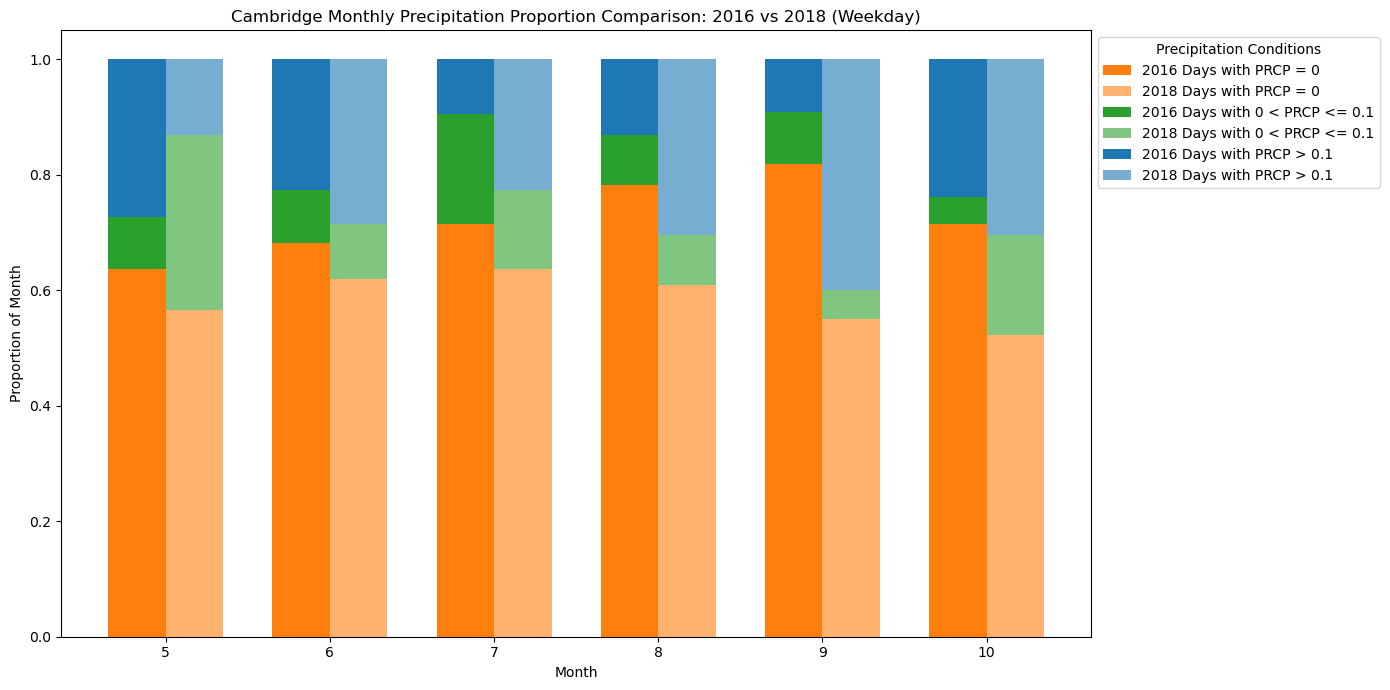

In [9]:
conditions = {
    'PRCP = 0': lambda x: x['PRCP (Inches)'] == 0,
    '0 < PRCP <= 0.1': lambda x: (x['PRCP (Inches)'] > 0) & (x['PRCP (Inches)'] <= 0.1),
    'PRCP > 0.1': lambda x: x['PRCP (Inches)'] > 0.1
}

labels = {
    'PRCP = 0': 'Days with PRCP = 0',
    '0 < PRCP <= 0.1': 'Days with 0 < PRCP <= 0.1',
    'PRCP > 0.1': 'Days with PRCP > 0.1'
}

color_map = {
    'PRCP = 0': 'tab:orange',
    '0 < PRCP <= 0.1': 'tab:green',
    'PRCP > 0.1': 'tab:blue'
}

counts_2016 = {condition: [] for condition in conditions}
counts_2018 = {condition: [] for condition in conditions}

total_days_2016 = percp_16.groupby('month').size()
total_days_2018 = percp_18.groupby('month').size()

for month in range(5, 11):
    percp_16_month = percp_16[percp_16['month'] == month]
    percp_18_month = percp_18[percp_18['month'] == month]
    for label, condition in conditions.items():
        counts_2016[label].append(percp_16_month[condition(percp_16_month)].shape[0] / total_days_2016[month])
        counts_2018[label].append(percp_18_month[condition(percp_18_month)].shape[0] / total_days_2018[month])

df_2016 = pd.DataFrame(counts_2016, index=range(5, 11))
df_2018 = pd.DataFrame(counts_2018, index=range(5, 11))

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.35 

bottom_2016 = np.zeros(len(df_2016))
bottom_2018 = np.zeros(len(df_2018))

for condition, label in labels.items():
    color = color_map[condition]
    ax.bar(df_2016.index - width/2, df_2016[condition], width, bottom=bottom_2016, label=f'2016 {label}', color=color)
    ax.bar(df_2018.index + width/2, df_2018[condition], width, bottom=bottom_2018, label=f'2018 {label}', color=color, alpha=0.6)
    bottom_2016 += df_2016[condition]
    bottom_2018 += df_2018[condition]

ax.set_xlabel('Month')
ax.set_ylabel('Proportion of Month')
ax.set_title('Cambridge Monthly Precipitation Proportion Comparison: 2016 vs 2018 (Weekday)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Precipitation Conditions')
plt.xticks(range(5, 11))
plt.tight_layout()
plt.show()


In [32]:
def filter_weather(sp_trips_df, percp_16, percp_18, months, hours, precip_threshold=0):
    sp_16 = sp_trips_df[sp_trips_df['year'] == 2016].copy()
    sp_18 = sp_trips_df[sp_trips_df['year'] == 2018].copy()

    sp_16 = pd.merge(sp_16, percp_16[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')
    sp_18 = pd.merge(sp_18, percp_18[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')

    # Merge with Boston precipitation data
    # sp_16 = pd.merge(sp_16, percp_16b[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left', suffixes=('', '_boston'))
    # sp_18 = pd.merge(sp_18, percp_18b[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left', suffixes=('', '_boston'))

    # Fill missing values with 100 (arbitrary big number to indicate no data)
    sp_16['PRCP (Inches)'] = sp_16['PRCP (Inches)'].fillna(100)
    sp_18['PRCP (Inches)'] = sp_18['PRCP (Inches)'].fillna(100)
    # sp_16['PRCP (Inches)_boston'] = sp_16['PRCP (Inches)_boston'].fillna(0)
    # sp_18['PRCP (Inches)_boston'] = sp_18['PRCP (Inches)_boston'].fillna(0)

    # sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] <= 0.1) & (sp_16['PRCP (Inches)'] > precip_threshold)]
    # sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] <= 0.1) & (sp_18['PRCP (Inches)'] > precip_threshold)]

    sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] >= 0)]
    sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] >= 0)]
    # sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] == precip_threshold)]
    # sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] == precip_threshold)]

    sp_16_nice = sp_16_nice[sp_16_nice['month'].isin(months) & sp_16_nice['hour'].isin(hours)]
    sp_18_nice = sp_18_nice[sp_18_nice['month'].isin(months) & sp_18_nice['hour'].isin(hours)]
    sp_trips_nice = pd.concat([sp_16_nice, sp_18_nice])

    return sp_16_nice, sp_18_nice, sp_trips_nice, sp_16, sp_18

In [33]:
months = range(5,13)
hours = range(6,23)
sp_16_nice, sp_18_nice, sp_trips_nice, sp_16, sp_18 = filter_weather(sp_trips_uf, percp_16, percp_18, months, hours)
data_16_nice, data_18_nice, data_all_nice, all_16, all_18= filter_weather(data_all_uf, percp_16, percp_18, months, hours)
# data_16_nice2, data_18_nice2, data_all_nice2, all_162, all_182= filter_weather(data_all, percp_16, percp_18, months, hours)

In [34]:
def plot_trip_comparison(sp_trips, da, hour_range, title_suffix, plot_waifw=False, month_range=range(5, 13)):
    
    # Filter data for 2016 and 2018, and the given hour range
    def filter_data(year):
        return (sp_trips[(sp_trips['year'] == year) & (sp_trips['hour'].isin(hour_range)) & (sp_trips['month'].isin(month_range))],
                da[(da['year'] == year) & (da['hour'].isin(hour_range)) & (da['month'].isin(month_range))])
    
    t16, n16 = filter_data(2016)
    t18, n18 = filter_data(2018)
    
    if plot_waifw:
        
        def count_trips(data, dall, side_right, side_left):
            return (data[(data['start station id'].isin(side_right)) & (data['end station id'].isin(side_left))].shape[0],
                    data[(data['start station id'].isin(side_left)) & (data['end station id'].isin(side_right))].shape[0],
                    dall[(dall['start station id'].isin(side_right)) & (dall['end station id'].isin(side_right))].shape[0],
                    dall[(dall['start station id'].isin(side_left)) & (dall['end station id'].isin(side_left))].shape[0])
        
        rl_16, lr_16, rr_16, ll_16 = count_trips(t16, n16, side_right, side_left)
        rl_18, lr_18, rr_18, ll_18 = count_trips(t18, n18, side_right, side_left)
        
        total_trips_16 = rl_16 + lr_16 + rr_16 + ll_16
        total_trips_18 = rl_18 + lr_18 + rr_18 + ll_18
        
        waifw_matrix_16 = np.array([[ll_16, lr_16], [rl_16, rr_16]]) / total_trips_16
        waifw_matrix_18 = np.array([[ll_18, lr_18], [rl_18, rr_18]]) / total_trips_18
        
        def plot_heatmap(data, title, ax):
            sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, ax=ax)
            ax.set_title(title)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        plot_heatmap(pd.DataFrame(waifw_matrix_16, columns=['To_Left', 'To_Right'], index=['From_Left', 'From_Right']),
                     f'Normalized WAIFW 2016 ({title_suffix})', axes[0])
        plot_heatmap(pd.DataFrame(waifw_matrix_18, columns=['To_Left', 'To_Right'], index=['From_Left', 'From_Right']),
                     f'Normalized WAIFW 2018 ({title_suffix})', axes[1])
        plt.tight_layout()
        plt.show()
        
    else:
        def calculate_trip_counts(t, n):
            trips = t.groupby('month').size().reset_index(name='trip_count')
            total_trips = n.groupby('month').size().reset_index(name='total_trip_count')
            trips = pd.merge(trips, total_trips, on='month')
            trips['normalized_trip_count'] = trips['trip_count'] / trips['total_trip_count']
            return trips
        
        trips_2016 = calculate_trip_counts(t16, n16)
        trips_2018 = calculate_trip_counts(t18, n18)
        
        trips_normalized = pd.merge(trips_2016[['month', 'normalized_trip_count']], 
                                    trips_2018[['month', 'normalized_trip_count']], 
                                    on='month', suffixes=('_2016', '_2018'))
        
        def plot_bar(trips, ax, normalized=False):
            width = 0.4
            if normalized:
                ax.bar(trips['month'] - width/2, trips['normalized_trip_count_2016'], width=width, label='2016')
                ax.bar(trips['month'] + width/2, trips['normalized_trip_count_2018'], width=width, label='2018')
                ax.set_ylabel('Normalized')
                # ax.set_title(f'Normalized')
            else:
                ax.bar(trips['month'] - width/2, trips['trip_count_2016'], width=width, label='2016')
                ax.bar(trips['month'] + width/2, trips['trip_count_2018'], width=width, label='2018')
                ax.set_ylabel('Number of Trips')
                ax.set_title(f'Number of Trips per Month: 2016 vs 2018 ({title_suffix})')
            ax.set_xlabel('Month')
            # ax.set_xticks(range(6, 13))
            ax.legend()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        trips = pd.merge(trips_2016[['month', 'trip_count']], trips_2018[['month', 'trip_count']], on='month', suffixes=('_2016', '_2018'))
        plot_bar(trips, axes[0])
        plot_bar(trips_normalized, axes[1], normalized=True)
        
        plt.tight_layout()
        plt.show()

In [35]:
trips_cam_dist = pd.read_csv("result/trips_cam_dist.csv")

In [36]:
cam_all_unfilt = pd.merge(sp_trips_nice, trips_cam_dist[['start station id', 'end station id', 'distance (km)']], on=['start station id', 'end station id'], how='left')
cam_all_unfilt.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,hour,month,year,day,age,PRCP (Inches),distance (km)
0,281,2016-05-10 06:13:55,2016-05-10 06:18:37,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,110,Harvard University Gund Hall at Quincy St / Ki...,42.376369,...,Subscriber,1987,1,6,5,2016,10,29,0.00,1.2
1,689,2016-05-10 06:37:01,2016-05-10 06:48:31,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,104,Harvard University Radcliffe Quadrangle at She...,42.380287,...,Subscriber,1978,2,6,5,2016,10,38,0.00,3.2
2,1406,2016-05-26 06:33:25,2016-05-26 06:56:52,43,Rowes Wharf - Atlantic Ave,42.357143,-71.050699,108,Harvard University / SEAS Cruft-Pierce Halls a...,42.377945,...,Subscriber,1958,1,6,5,2016,26,58,0.00,6.8
3,1469,2016-05-31 06:50:31,2016-05-31 07:15:01,98,Charlestown - Warren St at Chelsea St,42.371848,-71.060292,108,Harvard University / SEAS Cruft-Pierce Halls a...,42.377945,...,Subscriber,1974,2,6,5,2016,31,42,0.17,5.5
4,1996,2016-05-10 06:25:07,2016-05-10 06:58:24,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,54,Tremont St / West St,42.354979,...,Subscriber,1967,1,6,5,2016,10,49,0.00,8.2


In [37]:
num_rows_with_nan = cam_all_unfilt.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {num_rows_with_nan}")

Number of rows with NaN values: 2


In [46]:
def categorize_distance(distance):
    if distance < 1.6:
        return 'Short'
    elif 1.6 <= distance <= 6:
        return 'Medium'
    else:
        return 'Long'
        
def categorize_day(prcp):
    return 'wet' if prcp > 0 else 'dry'

def categorize_time_period(month, hour):
    if month in [6, 7, 8]:
        if 7 <= hour <= 10:
            return 'Summer Morning'
        elif 16 <= hour <= 20:
            return 'Summer Afternoon'
    elif month in [5, 9, 10]:
        if 7 <= hour <= 10:
            return 'Non-Summer Morning'
        elif 16 <= hour <= 20:
            return 'Non-Summer Afternoon'
    return None

In [52]:
cam_all_unfilt['distance_category'] = cam_all_unfilt['distance (km)'].apply(categorize_distance)
cam_all_unfilt['speed (km/h)'] = cam_all_unfilt['distance (km)'] / (cam_all_unfilt['tripduration'] / 3600)
cam_all_unfilt['day_type'] = cam_all_unfilt['PRCP (Inches)'].apply(categorize_day)
cam_all_unfilt['time_period'] = cam_all_unfilt.apply(lambda x: categorize_time_period(x['month'], x['hour']), axis=1)

data_2016 = cam_all_unfilt[(cam_all_unfilt['year'] == 2016) & (cam_all_unfilt['time_period'].notnull()) & (cam_all_unfilt['age'] < 46)].copy()
data_2018 = cam_all_unfilt[(cam_all_unfilt['year'] == 2018) & (cam_all_unfilt['time_period'].notnull()) & (cam_all_unfilt['age'] < 46)].copy()
data_2016['gender_label'] = data_2016['gender'].map({1: 'Male', 2: 'Female'})
data_2018['gender_label'] = data_2018['gender'].map({1: 'Male', 2: 'Female'})

results_2016 = []
results_2018 = []

for distance_category in ['Short', 'Medium', 'Long']:
    for gender_label in ['Male', 'Female']:
        for time_period in ['Summer Morning', 'Summer Afternoon', 'Non-Summer Morning', 'Non-Summer Afternoon']:
            speeds_dry_2016 = data_2016[(data_2016['distance_category'] == distance_category) & 
                                        (data_2016['gender_label'] == gender_label) & 
                                        (data_2016['time_period'] == time_period) & 
                                        (data_2016['day_type'] == 'dry')]['speed (km/h)']
            speeds_wet_2016 = data_2016[(data_2016['distance_category'] == distance_category) & 
                                        (data_2016['gender_label'] == gender_label) & 
                                        (data_2016['time_period'] == time_period) & 
                                        (data_2016['day_type'] == 'wet')]['speed (km/h)']
            speeds_dry_2018 = data_2018[(data_2018['distance_category'] == distance_category) & 
                                        (data_2018['gender_label'] == gender_label) & 
                                        (data_2018['time_period'] == time_period) & 
                                        (data_2018['day_type'] == 'dry')]['speed (km/h)']
            speeds_wet_2018 = data_2018[(data_2018['distance_category'] == distance_category) & 
                                        (data_2018['gender_label'] == gender_label) & 
                                        (data_2018['time_period'] == time_period) & 
                                        (data_2018['day_type'] == 'wet')]['speed (km/h)']
            
            if not speeds_dry_2016.empty and not speeds_wet_2016.empty:
                u_stat, p_val = mannwhitneyu(speeds_dry_2016, speeds_wet_2016)
                difference = speeds_dry_2016.median() - speeds_wet_2016.median()
                if p_val >= 0.05:
                    difference = 0 #if not significant, put 0
                results_2016.append({'distance_category': distance_category,
                                     'gender_label': gender_label,
                                     'time_period': time_period,
                                     'difference': difference})
            
            if not speeds_dry_2018.empty and not speeds_wet_2018.empty:
                u_stat, p_val = mannwhitneyu(speeds_dry_2018, speeds_wet_2018)
                difference = speeds_dry_2018.median() - speeds_wet_2018.median()
                if p_val >= 0.05:
                    difference = 0
                results_2018.append({'distance_category': distance_category,
                                     'gender_label': gender_label,
                                     'time_period': time_period,
                                     'difference': difference})

results_2016_df = pd.DataFrame(results_2016)
results_2018_df = pd.DataFrame(results_2018)

In [58]:
merged_results = pd.merge(results_2016_df, results_2018_df, on=['distance_category', 'gender_label', 'time_period'], suffixes=('_2016(km/h)', '_2018(km/h)'))
merged_results['difference_diff(km/h)'] = merged_results['difference_2018(km/h)'] - merged_results['difference_2016(km/h)']

In [59]:
merged_results[merged_results['distance_category']=='Long']

,distance_category,gender_label,time_period,difference_2016(km/h),difference_2018(km/h),difference_diff(km/h)
16,Long,Male,Summer Morning,0,-0.957829,-0.957829
17,Long,Male,Summer Afternoon,0,0.000000,0.000000
18,Long,Male,Non-Summer Morning,0,-0.336735,-0.336735
19,Long,Male,Non-Summer Afternoon,0,0.000000,0.000000
20,Long,Female,Summer Morning,0,0.000000,0.000000
21,Long,Female,Summer Afternoon,0,0.000000,0.000000
22,Long,Female,Non-Summer Morning,0,0.000000,0.000000
23,Long,Female,Non-Summer Afternoon,0,-0.263004,-0.263004
